<a href="https://colab.research.google.com/github/Attabeezy/sequential-crm-for-dce/blob/main/credit_risk_prediction_v1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Some add ons:
- Divide the `Fully paid` class by 2 and upsample the minority class to that number.
- Try both upsample and downsample, 60-40, 70-30 options, use cross-validation instead.
- Go backk to the original data, Lending club, do sample with `stratify`

`Macro-f1`, `sensitivity/precision`, `classification_report`, `ROC AUC`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub
#kagglehub.login()

dataset_path = kagglehub.dataset_download('jeandedieunyandwi/lending-club-dataset')

print(f"Dataset downloaded to: {dataset_path}")

100%|██████████| 27.6M/27.6M [00:00<00:00, 222MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/jeandedieunyandwi/lending-club-dataset/versions/1


In [ ]:
#!pip install tensorflow
#!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, classification_report
import warnings
import io

warnings.filterwarnings('ignore') # for suppressing warnings. cleaner output

##Setup and Data Loading

In [ ]:
file_path = f"{dataset_path}/lending_club_loan_two.csv"

df = pd.read_csv(file_path)

df['loan_status'].head()

,loan_status
0,Fully Paid
1,Fully Paid
2,Fully Paid
3,Fully Paid
4,Charged Off


In [ ]:
df['loan_status'].value_counts(normalize=True)

,proportion
loan_status,
Fully Paid,0.803871
Charged Off,0.196129


In [ ]:
df[df['loan_status'] == 'Charged Off'].shape[0] // 2

38836

## Data Preprocessing

In [ ]:
## TARGET VARIABLE AND INITIAL FILTER
# MAP LOAN_STATUS TO BINARY TARGET VARIABLE. WITH 0=DEFAULT AND 1=NOT DEFAULT
# CONSIDERING FULLY PAID AS NOT DEFAULT AND VICE VERSA FOR CHARGED OFF

df_clean = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()
df_clean['loan_status_binary'] = df_clean['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)

# Separate features and target before splitting
X_clean = df_clean.drop('loan_status_binary', axis=1)
y_clean = df_clean['loan_status_binary']


# SPLITTING DATA INTO TRAIN AND TEST TESTS STRATIFIED BY LOAN STATUS
# This ensures both classes are present in train and test sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)


SAMPLE_SIZE = 60000 # paper used a sample size of 60,000 records

if len(X_train_full) > SAMPLE_SIZE:
    # Sample from the full training set
    train_indices = X_train_full.sample(n=SAMPLE_SIZE, random_state=42).index
    df_sampled = df_clean.loc[train_indices].copy()
    print(f"Data sampled to {SAMPLE_SIZE} records from the training set.")
else:
    # Use the full training set if its smaller than SAMPLE_SIZE
    df_sampled = df_clean.loc[X_train_full.index].copy()
    print(f"Data has {len(df_sampled)} records. No sampling performed.")

# Recombine features and target for the sampled data
X_sampled = df_sampled.drop('loan_status_binary', axis=1)
y_sampled = df_sampled['loan_status_binary']


## FEATURE SELECTION AND CLEANING
# SELECTING FEATURES USED IN PAPER
FEATURE_COLUMNS = [
    'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
    'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'annual_inc', 'application_type'
]

# CHECK FOR COLUMNS AVAILABILITY BASED ON RESEARCH PAPERS SELECTIONS
available_cols = [col for col in FEATURE_COLUMNS if col in X_sampled.columns]

if len(available_cols) == len(FEATURE_COLUMNS):
    print("All columns are available.")
else:
    missing_cols = set(FEATURE_COLUMNS) - set(available_cols)
    print(f"The following columns are missing: {missing_cols}")

# CLEANING CATEGORICAL AND STRING COLUMNS TO BE NUMERIC
# 1. 'term': Remove 'months' and convert to float
if 'term' in X_sampled.columns:
    if X_sampled['term'].dtype == 'object': # Check if the column is of string type
        X_sampled['term'] = X_sampled['term'].str.replace(' months', '', regex = False).astype(float)
    else:
        print("Warning: 'term' column is not of string type. Skipping string cleaning.")


# 2. 'int_rate': Remove percentage and convert to float
if 'int_rate' in X_sampled.columns:
    if X_sampled['int_rate'].dtype == 'object': # Check if the column is of string type
        X_sampled['int_rate'] = X_sampled['int_rate'].str.replace('%', '', regex = False).astype(float)
    else:
         print("Warning: 'int_rate' column is not of string type. Skipping string cleaning.")

# 3. 'emp_length': convert strings to numeric (0-10)
if 'emp_length' in X_sampled.columns:
    if X_sampled['emp_length'].dtype == 'object': # Check if the column is of string type
        X_sampled['emp_length'] = X_sampled['emp_length'].replace({
            '< 1 year': '0', '1 year': '1', '2 years': '2', '3 years': '3', '4 years': '4',
            '5 years': '5', '6 years': '6', '7 years': '7', '8 years': '8', '9 years': '9',
            '10+ years': '10', 'n/a': np.nan
        }).astype(float)
    else:
        print("Warning: 'emp_length' column is not of string type. Skipping string cleaning.")


# SELECT FINAL WORKING FEATURES
final_features = [col for col in available_cols if X_sampled[col].dtype in ['float64', 'int64']]
# ALSO INCLUDE CATEGORICAL FEATURES THAT NEED ONE-HOT ENCODING
categorical_features = ['grade', 'application_type']
final_features.extend([c for c in categorical_features if c in X_sampled.columns])

X_final = X_sampled[final_features].copy()
y_final = y_sampled.copy()

# Drop NaNs after selecting final features
combined_df = pd.concat([X_final, y_final], axis=1)
combined_df.dropna(inplace=True)

X_final = combined_df.drop('loan_status_binary', axis=1)
y_final = combined_df['loan_status_binary']

print(f"Data after cleaning and dropping NaNs: {X_final.shape[0]} records.")

# ONE-HOT ENCODE CATEGORICAL VARIABLES ('grade', 'application_type')
X_encoded = pd.get_dummies(X_final, columns = [c for c in categorical_features if c in X_final.columns], drop_first=True)
X = X_encoded.copy()
y = y_final.copy()
print(f"Total input features after one-hot encoding: {X.shape[1]}")


## SPLITTING AND NORMALIZATION (Min-Max)
# Use the stratified test set created earlier
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# NORMALIZING FEATURES WITH Min-Max Linear Transformation
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Train/Test split: {X_train.shape[0]} / {X_test.shape[0]} samples.")
print("Features normalized (0 to 1) using Min-Max scaler.")

Data sampled to 60000 records from the training set.
The following columns are missing: {'funded_amnt', 'funded_amnt_inv'}
Data after cleaning and dropping NaNs: 57265 records.
Total input features after one-hot encoding: 14
Train/Test split: 45812 / 11453 samples.
Features normalized (0 to 1) using Min-Max scaler.


## Logistic Regression Implementation


In [ ]:
# LR as stand-in for paper's GLM/Linear Regression for classification
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Apply the 0.5 probability cutoff for classification
y_pred_lr = (y_pred_lr_proba > 0.5).astype(int)

lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_mse = mean_squared_error(y_test, y_pred_lr_proba)

print(f"Logistic Regression test accuracy: {lr_accuracy:.6f}")
print(f"Logistic Regression test MSE: {lr_mse:.7f}")

Logistic Regression test accuracy: 0.806776
Logistic Regression test MSE: 0.1434985


## XGBoost Implementation

In [ ]:
import xgboost as xgb

# Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Apply the 0.5 probability cutoff for classification
y_pred_xgb = (y_pred_xgb_proba > 0.5).astype(int)

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_mse = mean_squared_error(y_test, y_pred_xgb_proba)

print(f"XGBoost test accuracy: {xgb_accuracy:.6f}")
print(f"XGBoost test MSE: {xgb_mse:.7f}")

XGBoost test accuracy: 0.803196
XGBoost test MSE: 0.1457206


## Artificial Neural Network (ANN) Implementation

In [ ]:
# ANN Architecture
input_dim = X_train_scaled.shape[1]
hidden_neurons = 7 #testing number, may adjust

model = tf.keras.Sequential([
    # Input Layer (implicitly defined by input_shape) -> Hidden Layer (7 neurons)
    tf.keras.layers.Dense(hidden_neurons, activation='relu', input_shape=(input_dim,)),
    # Output Layer (1 neuron for binary classification)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compiling model with Adam for backpropagation
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train model
print(f"Training ANN with {input_dim} inputs, 1 hidden layer of {hidden_neurons} neurons, and 1 output.")
history = model.fit(X_train_scaled, y_train,
                    epochs = 50, #testing number, may adjust
                    batch_size = 32, #testing number, may adjust
                    validation_data = (X_test_scaled, y_test)
                    )

# Make predictions and evaluate
y_pred_ann_proba = model.predict(X_test_scaled).flatten()
y_pred_ann = (y_pred_ann_proba > 0.5).astype(int)

ann_accuracy = accuracy_score(y_test, y_pred_ann)
ann_mse = mean_squared_error(y_test, y_pred_ann_proba) # MSE for prob of output

print(f"ANN test accuracy: {ann_accuracy}")
print(f"ANN test MSE: {ann_mse}")

Training ANN with 14 inputs, 1 hidden layer of 7 neurons, and 1 output.
Epoch 1/50
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.6845 - loss: 0.5693 - val_accuracy: 0.8071 - val_loss: 0.4646
Epoch 2/50
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8061 - loss: 0.4671 - val_accuracy: 0.8067 - val_loss: 0.4592
Epoch 3/50
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8069 - loss: 0.4605 - val_accuracy: 0.8072 - val_loss: 0.4560
Epoch 4/50
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8091 - loss: 0.4564 - val_accuracy: 0.8070 - val_loss: 0.4537
Epoch 5/50
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8074 - loss: 0.4582 - val_accuracy: 0.8069 - val_loss: 0.4528
Epoch 6/50
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8064 - loss: 0.4583 - val_accuracy: 0.8070 - val_loss: 0.4521
Epoch 7/50
1432/1432 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8066 - loss: 0.4578 - val_accuracy: 0.8071 - val_loss: 0.4522
Epoch 8/50
1432/1

## Evaluation and Comparison

Logistic Regression AUC-ROC: 0.698765
XGBoost AUC-ROC: 0.689531
ANN AUC-ROC: 0.701924


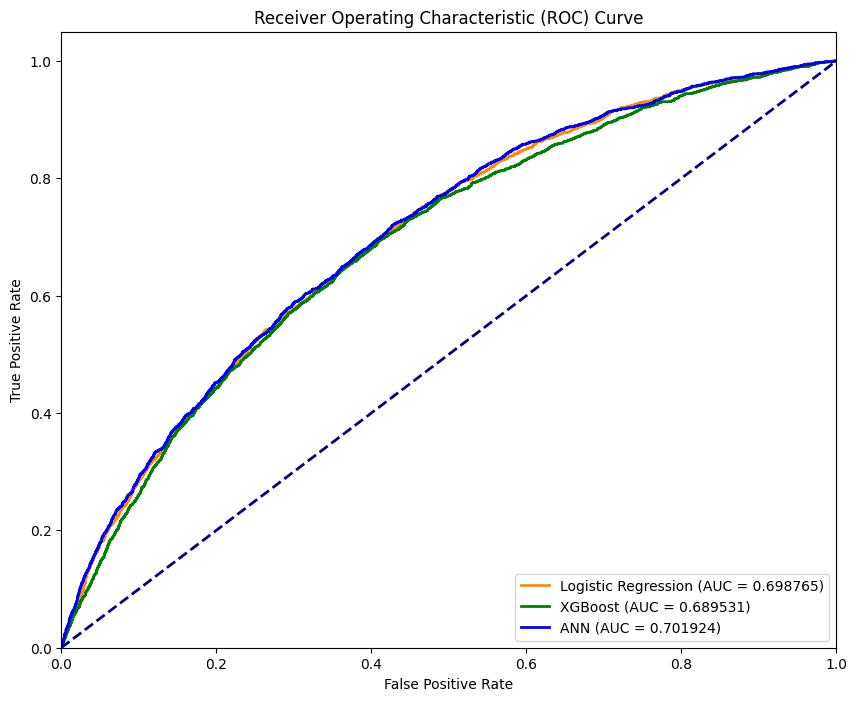

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr_proba)
auc_lr = auc(fpr_lr, tpr_lr)

# Calculate ROC curve and AUC for XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb_proba)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Calculate ROC curve and AUC for ANN
fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test, y_pred_ann_proba)
auc_ann = auc(fpr_ann, tpr_ann)

print(f"Logistic Regression AUC-ROC: {auc_lr:.6f}")
print(f"XGBoost AUC-ROC: {auc_xgb:.6f}")
print(f"ANN AUC-ROC: {auc_ann:.6f}")

# Visualize ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {auc_lr:.6f})')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {auc_xgb:.6f})')
plt.plot(fpr_ann, tpr_ann, color='blue', lw=2, label=f'ANN (AUC = {auc_ann:.6f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Comparison Table (Table 2 from paper)
print("\nTable: Mean Squared Error of both processes (Replication)")
print(pd.DataFrame({
    'Model': ['MSE of ANN', 'MSE of Logistic Regression'],
    'Mean Squared Error': [ann_mse, lr_mse]
}))

# Confusion Matrix (Fig. 6 for Logistic Regression from paper)
cm = confusion_matrix(y_test, y_pred_lr)
lr_report = classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0)
lr_acccuracy = lr_report['accuracy']

# Formatting Fig. 6 from paper (Prediction vs. Reference)
print("\nFig. 6. Confusion Matrix and Statistics of Logistic Regression")
confusion_df = pd.DataFrame(cm, columns=['Predicted Fully Paid', 'Predicted Charged Off'])
confusion_df.index = ['Actual Fully Paid', 'Actual Charged Off'] # Set index names for 'Reference'

print("\nActual")
print(confusion_df)
print(f"\nAccuracy: {lr_acccuracy:.7f}")

# Overall Conclusion
print("\nOverall Conclusion")
print(f"ANN achieved accuracy: {ann_accuracy:.6f}",
      f"\nANN achieved MSE: {ann_mse:.7f}")
print(f"Logistic Regression achieved accuracy: {lr_acccuracy:.6f}",
      f"\nLogistic Regression achieved MSE: {lr_mse:.7f}")

if np.isclose(ann_accuracy, lr_accuracy, atol=0.005):
    print("\nResult: Both models show approximately similar performance.")
elif ann_accuracy > lr_accuracy:
    print("\nResult: ANN outperforms Logistic Regression.")
else:
    print("\nResult: Logistic Regression outperforms ANN.")


Table: Mean Squared Error of both processes (Replication)
                        Model  Mean Squared Error
0                  MSE of ANN            0.142974
1  MSE of Logistic Regression            0.143498

Fig. 6. Confusion Matrix and Statistics of Logistic Regression

Actual
                    Predicted Fully Paid  Predicted Charged Off
Actual Fully Paid                   9213                     29
Actual Charged Off                  2184                     27

Accuracy: 0.8067755

Overall Conclusion
ANN achieved accuracy: 0.807474 
ANN achieved MSE: 0.1429738
Logistic Regression achieved accuracy: 0.806776 
Logistic Regression achieved MSE: 0.1434985

Result: Both models show approximately similar performance.


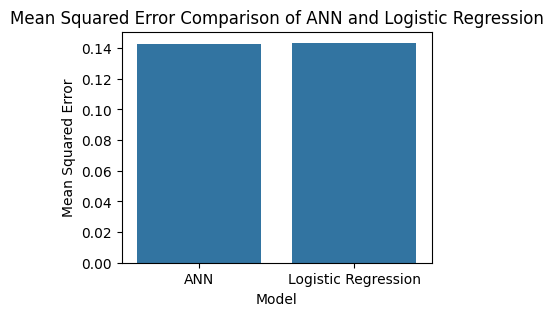

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize MSE comparison
mse_df = pd.DataFrame({
    'Model': ['ANN', 'Logistic Regression'],
    'Mean Squared Error': [ann_mse, lr_mse]
})

plt.figure(figsize=(4, 3))
sns.barplot(x='Model', y='Mean Squared Error', data=mse_df)
plt.title('Mean Squared Error Comparison of ANN and Logistic Regression')
plt.ylabel('Mean Squared Error')
plt.show()

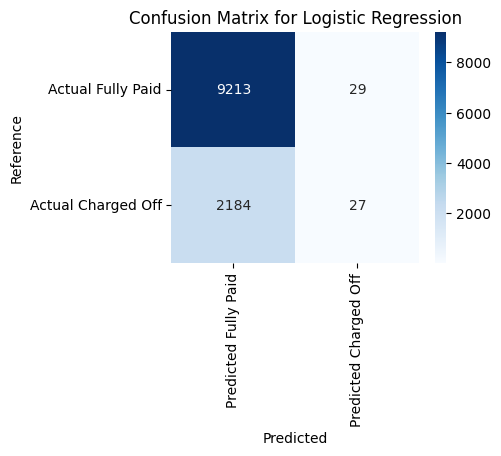

In [ ]:
# Visualize Logistic Regression Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Reference')
plt.show()


Fig. X. Confusion Matrix and Statistics of Artificial Neural Network (ANN)

Actual
                    Predicted Fully Paid  Predicted Charged Off
Actual Fully Paid                   9176                     66
Actual Charged Off                  2139                     72

Accuracy: 0.8074740


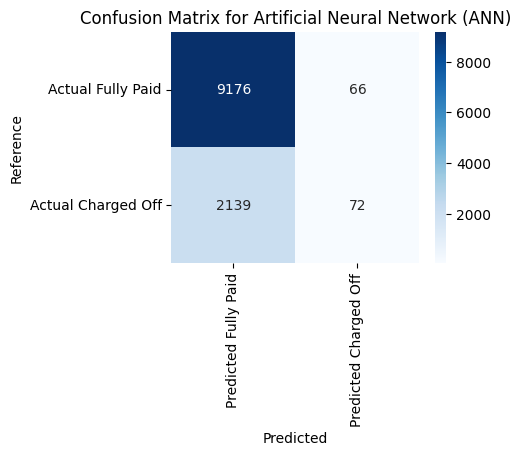


Fig. Y. Confusion Matrix and Statistics of XGBoost

Actual
                    Predicted Fully Paid  Predicted Charged Off
Actual Fully Paid                   9058                    184
Actual Charged Off                  2070                    141

Accuracy: 0.8031957


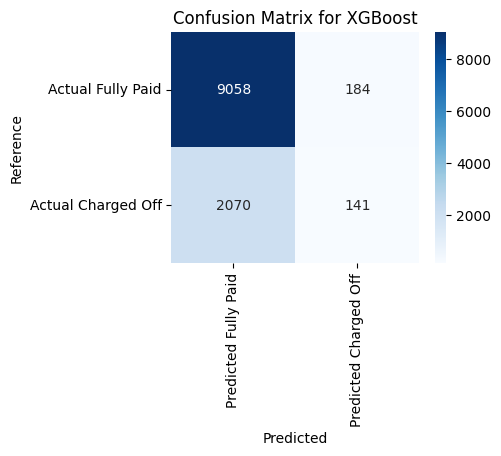

In [ ]:
# Confusion Matrix for ANN
cm_ann = confusion_matrix(y_test, y_pred_ann)
ann_report = classification_report(y_test, y_pred_ann, output_dict=True, zero_division=0)
ann_accuracy_report = ann_report['accuracy'] # Get accuracy from the classification report

print("\nFig. X. Confusion Matrix and Statistics of Artificial Neural Network (ANN)")
confusion_df_ann = pd.DataFrame(cm_ann, columns=['Predicted Fully Paid', 'Predicted Charged Off'])
confusion_df_ann.index = ['Actual Fully Paid', 'Actual Charged Off']

print("\nActual")
print(confusion_df_ann)
print(f"\nAccuracy: {ann_accuracy_report:.7f}")

# Visualize ANN Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_df_ann, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Artificial Neural Network (ANN)')
plt.xlabel('Predicted')
plt.ylabel('Reference')
plt.show()

# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
xgb_report = classification_report(y_test, y_pred_xgb, output_dict=True, zero_division=0)
xgb_accuracy_report = xgb_report['accuracy'] # Get accuracy from the classification report

print("\nFig. Y. Confusion Matrix and Statistics of XGBoost")
confusion_df_xgb = pd.DataFrame(cm_xgb, columns=['Predicted Fully Paid', 'Predicted Charged Off'])
confusion_df_xgb.index = ['Actual Fully Paid', 'Actual Charged Off']

print("\nActual")
print(confusion_df_xgb)
print(f"\nAccuracy: {xgb_accuracy_report:.7f}")

# Visualize XGBoost Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_df_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Reference')
plt.show()

## Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Classification report for Logistic Regression
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr, zero_division=0))

# Classification report for XGBoost
print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb, zero_division=0))

# Classification report for ANN
print("\nClassification Report for ANN:")
print(classification_report(y_test, y_pred_ann, zero_division=0))

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      9242
           1       0.48      0.01      0.02      2211

    accuracy                           0.81     11453
   macro avg       0.65      0.50      0.46     11453
weighted avg       0.75      0.81      0.73     11453


Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      9242
           1       0.43      0.06      0.11      2211

    accuracy                           0.80     11453
   macro avg       0.62      0.52      0.50     11453
weighted avg       0.74      0.80      0.74     11453


Classification Report for ANN:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      9242
           1       0.52      0.03      0.06      2211

    accuracy                           0.81     11453
   macro avg 